<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/poisson_regression_insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Poisson regression for predicting insurance claim rates

https://scikit-learn.org/stable/auto_examples/linear_model/plot_poisson_regression_non_normal_loss.html?highlight=poisson%20regression


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [1]:
import sklearn

print(sklearn.__version__)
from sklearn.linear_model import PoissonRegressor

0.24.2


# Data

In [3]:
from sklearn.datasets import fetch_openml


df = fetch_openml(data_id=41214, as_frame=True).frame
df

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1.0,0.10000,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
1,3.0,1.0,0.77000,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
2,5.0,1.0,0.75000,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22
3,10.0,1.0,0.09000,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
4,11.0,1.0,0.84000,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326.0,0.0,0.00274,E,4.0,0.0,54.0,50.0,B12,Regular,3317.0,R93
678009,6114327.0,0.0,0.00274,E,4.0,0.0,41.0,95.0,B12,Regular,9850.0,R11
678010,6114328.0,0.0,0.00274,D,6.0,2.0,45.0,50.0,B12,Diesel,1323.0,R82
678011,6114329.0,0.0,0.00274,B,4.0,0.0,60.0,50.0,B12,Regular,95.0,R26


Average Frequency = 0.10070308464041304
Fraction of exposure with zero claims = 93.9%


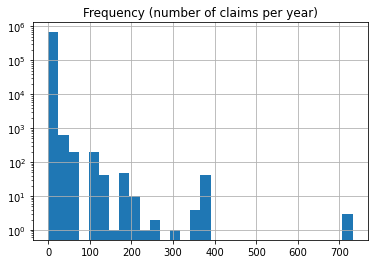

In [6]:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]

print("Average Frequency = {}".format(np.average(df["Frequency"], weights=df["Exposure"])))

print(
    "Fraction of exposure with zero claims = {0:.1%}".format(
        df.loc[df["ClaimNb"] == 0, "Exposure"].sum() / df["Exposure"].sum()
    )
)

fig, ax = plt.subplots()
ax.set_title("Frequency (number of claims per year)")
_ = df["Frequency"].hist(bins=30, log=True, ax=ax)

In [34]:
print(df["Frequency"][:-20])

0         10.000000
1          1.298701
2          1.333333
3         11.111111
4          1.190476
            ...    
677988     0.000000
677989     0.000000
677990     0.000000
677991     0.000000
677992     0.000000
Name: Frequency, Length: 677993, dtype: float64


In [7]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.33, random_state=0)

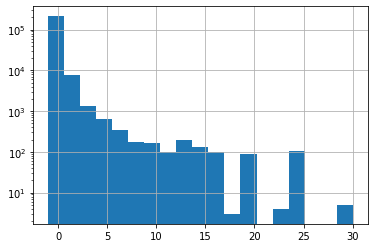

In [29]:
fig, ax = plt.subplots()
n_bins = 20
_ = df_test["Frequency"].hist(bins=np.linspace(-1, 30, n_bins), ax=ax)
ax.set_yscale("log")

# Feature engineering

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer


log_scale_transformer = make_pipeline(FunctionTransformer(np.log, validate=False), StandardScaler())

linear_model_preprocessor = ColumnTransformer(
    [
        ("passthrough_numeric", "passthrough", ["BonusMalus"]),
        ("binned_numeric", KBinsDiscretizer(n_bins=10), ["VehAge", "DrivAge"]),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
        ("onehot_categorical", OneHotEncoder(), ["VehBrand", "VehPower", "VehGas", "Region", "Area"]),
    ],
    remainder="drop",
)

# Evaluation metrics

In [9]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_poisson_deviance


def score_estimator(estimator, df_test):
    """Score an estimator on the test set."""
    y_pred = estimator.predict(df_test)

    print("MSE: %.3f" % mean_squared_error(df_test["Frequency"], y_pred, sample_weight=df_test["Exposure"]))
    print("MAE: %.3f" % mean_absolute_error(df_test["Frequency"], y_pred, sample_weight=df_test["Exposure"]))

    # Ignore non-positive predictions, as they are invalid for
    # the Poisson deviance.
    mask = y_pred > 0
    if (~mask).any():
        n_masked, n_samples = (~mask).sum(), mask.shape[0]
        print(
            f"WARNING: Estimator yields invalid, non-positive predictions "
            f" for {n_masked} samples out of {n_samples}. These predictions "
            f"are ignored when computing the Poisson deviance."
        )

    print(
        "mean Poisson deviance: %.3f"
        % mean_poisson_deviance(df_test["Frequency"][mask], y_pred[mask], sample_weight=df_test["Exposure"][mask])
    )

In [30]:
def plot_predictions(models):
    nmodels = len(models)
    height = 5
    width = 5 * (nmodels + 1)
    fig, axes = plt.subplots(nrows=1, ncols=nmodels + 1, figsize=(width, height), sharey=True)
    n_bins = 20
    df = df_test.copy()
    ax = axes[0]
    df["Frequency"].hist(bins=np.linspace(-1, 30, n_bins), ax=ax)
    ax.set_title("Data")
    ax.set_yscale("log")
    ax.set_xlabel("y (observed Frequency)")
    # ax.set_ylim([1e1, 5e5])
    ax.set_ylabel("#samples")

    for idx, model in enumerate(models):
        ax = axes[idx + 1]
        y_pred = model.predict(df)
        pd.Series(y_pred).hist(bins=np.linspace(-1, 4, n_bins), ax=ax)
        ax.set(title=model[-1].__class__.__name__, yscale="log", xlabel="y_pred (predicted expected Frequency)")

    plt.tight_layout()

# Dummy model

Just predicts overall mean.

In [35]:
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline

dummy = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", DummyRegressor(strategy="mean")),
    ]
).fit(df_train, df_train["Frequency"])

In [36]:
y_pred = dummy.predict(df_test)
print(y_pred[0:5])

[0.26520328 0.26520328 0.26520328 0.26520328 0.26520328]


We need to weight the examples by exposure, for reasons explained here:
https://github.com/scikit-learn/scikit-learn/issues/18059

In [37]:
# weighted version
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline

dummy = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", DummyRegressor(strategy="mean")),
    ]
).fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"])

In [38]:
y_pred = dummy.predict(df_test)
print(y_pred[0:5])

[0.10069261 0.10069261 0.10069261 0.10069261 0.10069261]


In [13]:
print("Constant mean frequency evaluation:")
score_estimator(dummy, df_test)

Constant mean frequency evaluation:
MSE: 0.564
MAE: 0.189
mean Poisson deviance: 0.625


# Linear regression

Linear regression is an okay baseline, but not the most appropriate model for count data... We see the L2 regularization to a small value, since the training set is large.


In [15]:
from sklearn.linear_model import Ridge


ridge_glm = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", Ridge(alpha=1e-6)),
    ]
).fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"])

In [16]:
print("Ridge evaluation:")
score_estimator(ridge_glm, df_test)

Ridge evaluation:
MSE: 0.560
MAE: 0.177
mean Poisson deviance: 0.601


# Poisson linear regression

We set the L2 regularizer to the same value as in ridge regression, but divided by the number of training samples, since poisson regression penalizes the average log likelihood.


In [17]:
from sklearn.linear_model import PoissonRegressor

n_samples = df_train.shape[0]

poisson_glm = Pipeline(
    [("preprocessor", linear_model_preprocessor), ("regressor", PoissonRegressor(alpha=1e-12, max_iter=300))]
)
poisson_glm.fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('passthrough_numeric',
                                                  'passthrough',
                                                  ['BonusMalus']),
                                                 ('binned_numeric',
                                                  KBinsDiscretizer(n_bins=10),
                                                  ['VehAge', 'DrivAge']),
                                                 ('log_scaled_numeric',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Density']),
                                 

In [18]:
print("PoissonRegressor evaluation:")
score_estimator(poisson_glm, df_test)

PoissonRegressor evaluation:
MSE: 0.560
MAE: 0.186
mean Poisson deviance: 0.594


# Comparison

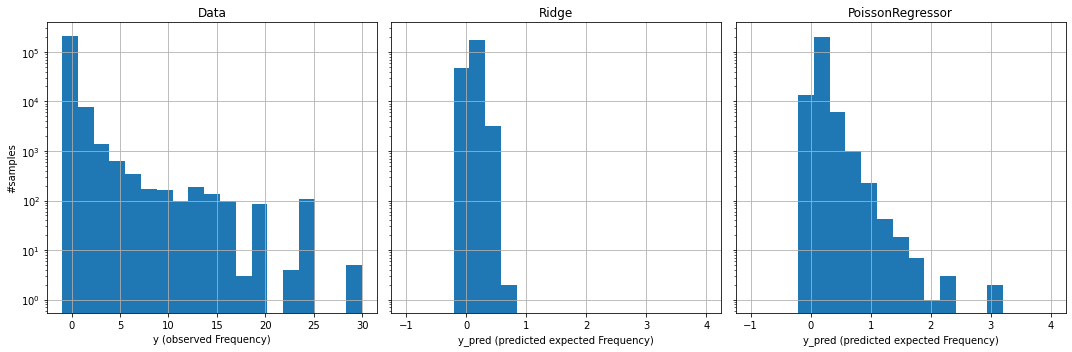

In [31]:
plot_predictions([ridge_glm, poisson_glm])

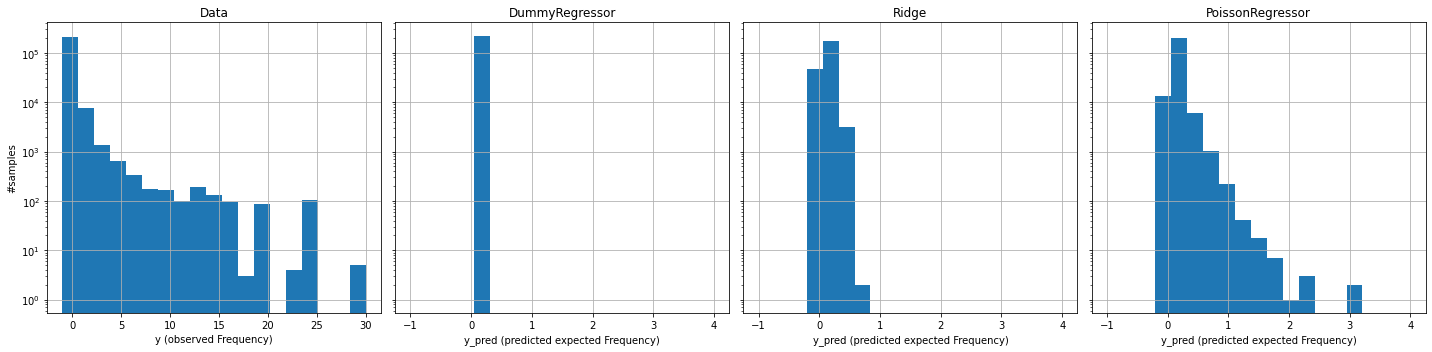

In [44]:
plot_predictions([dummy, ridge_glm, poisson_glm])
plt.savefig("poisson_regr_insurance_pred.pdf")

In [42]:
for model in [dummy, ridge_glm, poisson_glm]:
    print(model[-1].__class__.__name__)
    score_estimator(model, df_test)

DummyRegressor
MSE: 0.564
MAE: 0.189
mean Poisson deviance: 0.625
Ridge
MSE: 0.560
MAE: 0.177
mean Poisson deviance: 0.601
PoissonRegressor
MSE: 0.560
MAE: 0.186
mean Poisson deviance: 0.594


# Calibration plot

In [23]:
from sklearn.utils import gen_even_slices


def _mean_frequency_by_risk_group(y_true, y_pred, sample_weight=None, n_bins=100):
    """Compare predictions and observations for bins ordered by y_pred.

    We order the samples by ``y_pred`` and split it in bins.
    In each bin the observed mean is compared with the predicted mean.

    Parameters
    ----------
    y_true: array-like of shape (n_samples,)
        Ground truth (correct) target values.
    y_pred: array-like of shape (n_samples,)
        Estimated target values.
    sample_weight : array-like of shape (n_samples,)
        Sample weights.
    n_bins: int
        Number of bins to use.

    Returns
    -------
    bin_centers: ndarray of shape (n_bins,)
        bin centers
    y_true_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    y_pred_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    """
    idx_sort = np.argsort(y_pred)
    bin_centers = np.arange(0, 1, 1 / n_bins) + 0.5 / n_bins
    y_pred_bin = np.zeros(n_bins)
    y_true_bin = np.zeros(n_bins)

    for n, sl in enumerate(gen_even_slices(len(y_true), n_bins)):
        weights = sample_weight[idx_sort][sl]
        y_pred_bin[n] = np.average(y_pred[idx_sort][sl], weights=weights)
        y_true_bin[n] = np.average(y_true[idx_sort][sl], weights=weights)
    return bin_centers, y_true_bin, y_pred_bin


def plot_calibration(models):
    print(f"Actual number of claims: {df_test['ClaimNb'].sum()}")
    nmodels = len(models)
    height = 5
    width = 5 * (nmodels + 1)
    fig, ax = plt.subplots(nrows=1, ncols=nmodels, figsize=(width, height))
    plt.subplots_adjust(wspace=0.3)
    for axi, model in zip(ax.ravel(), models):
        y_pred = model.predict(df_test)
        y_true = df_test["Frequency"].values
        exposure = df_test["Exposure"].values
        q, y_true_seg, y_pred_seg = _mean_frequency_by_risk_group(y_true, y_pred, sample_weight=exposure, n_bins=10)

        # Name of the model after the estimator used in the last step of the
        # pipeline.
        print(f"Predicted number of claims by {model[-1]}: " f"{np.sum(y_pred * exposure):.1f}")

        axi.plot(q, y_pred_seg, marker="x", linestyle="--", label="predictions")
        axi.plot(q, y_true_seg, marker="o", linestyle="--", label="observations")
        axi.set_xlim(0, 1.0)
        axi.set_ylim(0, 0.5)
        axi.set(title=model[-1], xlabel="Fraction of samples sorted by y_pred", ylabel="Mean Frequency (y_pred)")
        axi.legend()
    plt.tight_layout()

Actual number of claims: 11935.0
Predicted number of claims by DummyRegressor(): 11931.2
Predicted number of claims by Ridge(alpha=1e-06): 10693.1
Predicted number of claims by PoissonRegressor(alpha=1e-12, max_iter=300): 11930.8


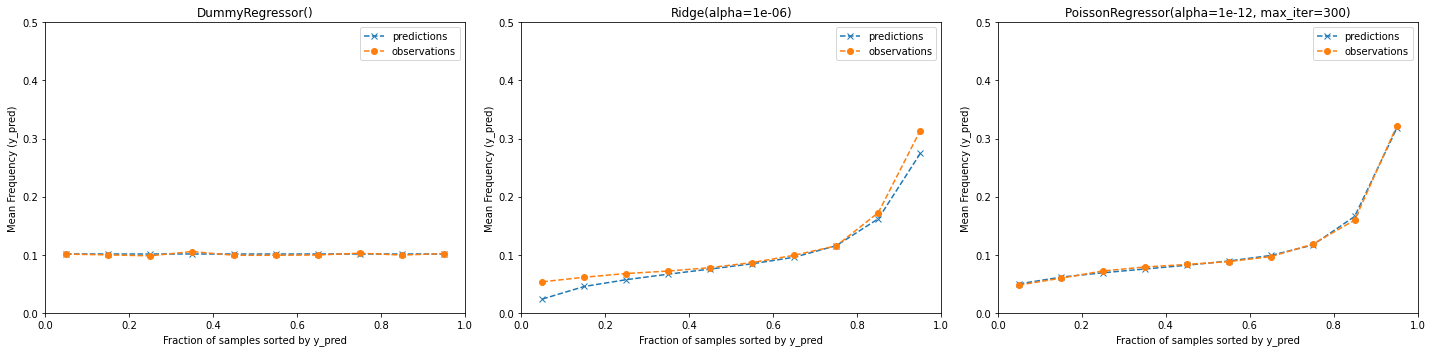

In [43]:
plot_calibration([dummy, ridge_glm, poisson_glm])
plt.savefig("poisson_regr_insurance.pdf")